![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# **Joaquin Abondano - 201728997**
# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [105]:
import warnings
warnings.filterwarnings('ignore')

In [167]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, mean_absolute_error, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

In [107]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

Promedio de bicicletas por estación:
season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Estadiscas descriptivas por estación:
         count        mean         std  min   25%    50%    75%    max
season                                                                
1       2686.0  116.343261  125.273974  1.0  24.0   78.0  164.0  801.0
2       2733.0  215.251372  192.007843  1.0  49.0  172.0  321.0  873.0
3       2733.0  234.417124  197.151001  1.0  68.0  195.0  347.0  977.0
4       2734.0  198.988296  177.622409  1.0  51.0  161.0  294.0  948.0


Text(0.5, 0, 'Estación')

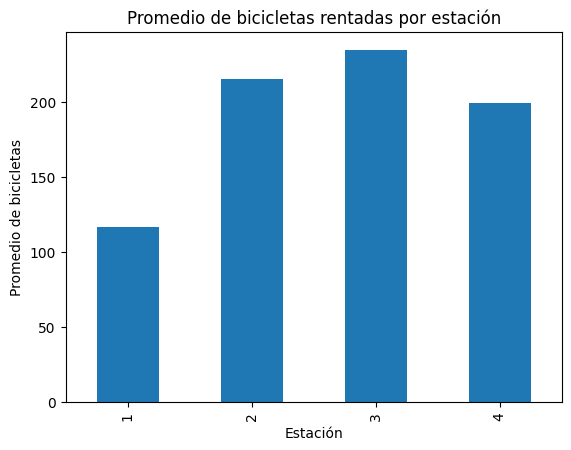

In [108]:
# Celda 1.1
# Homologacion 1:winter, 2:spring, 3:summer, 4:fall
conteo_estaciones = bikes.groupby('season').total.mean()
print("Promedio de bicicletas por estación:")
print(conteo_estaciones)

estaciones = bikes.groupby('season').total.describe()
print("\nEstadiscas descriptivas por estación:")
print(estaciones)

visual_conteo_estaciones = bikes.groupby('season').total.mean().plot(kind='bar', title='Promedio de bicicletas rentadas por estación')
visual_conteo_estaciones.set_ylabel('Promedio de bicicletas')
visual_conteo_estaciones.set_xlabel('Estación')

In [109]:
# Celda 1.2
promedio_hour = bikes.groupby('hour').total.mean()
print("Promedio de bicicletas por hora")
print(promedio_hour)

estadisticas_hour = bikes.groupby('hour').total.describe()
print("\nEstadísticas descriptivas de bicicletas por hora")
print(estadisticas_hour)

Promedio de bicicletas por hora
hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Estadísticas descriptivas de bicicletas por hora
      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    

#### **Hallazgos y conclusiones**

* **Variable season**:
  * La temporada con menor demanda es 1 (invierno), con un promedio de 116.34 bicicletas rentadas
  * La demanda aumenta significativamente en la temporada 2 (primavera) y alcanza su punto más alto en la temporada 3 (verano), con un promedio de 234.41 bicicletas
  * Para la cuarta temporada (otoño) se tiene un descenso frente al verano, pero sigue siendo superior al invierno con un promedio de 198.98 bicicletas
  * Mayor variabilidad en verano (desviación estándar cercana a 197)
  * El valor máximo de demanda también ocurre en verano (977 bicicletas)
  * El invierno muestra baja dispersión y menor demanda frente a las demás temporadas

* **Variable hour**:
  * El análisis de las bicicletas rentadas por hora muestra que la demanda promedio es muy baja durante la madrugada con un mínimo a las 4 am de 6.40 bicicletas rentadas
  * Al rededor de las 8 am crece la demanda registrando un valor promedio de 362.76
  * Durante el mediodía, la demanda desciende y vuelve a aumentar en la tarde
  * Posteriormente, la demanda decrece en la noche
  * Desviación estándar alta en horas pico (8 am y 5 pm): cerca de 230, indicando alta variabilidad
  * Máximo absoluto a las 5 pm: 977 bicicletas rentadas en una sola hora
  * Baja dispersión en horas de madrugada, lo que refleja un comportamiento estable y predecible de baja demanda


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

Text(0.5, 0, 'Hora')

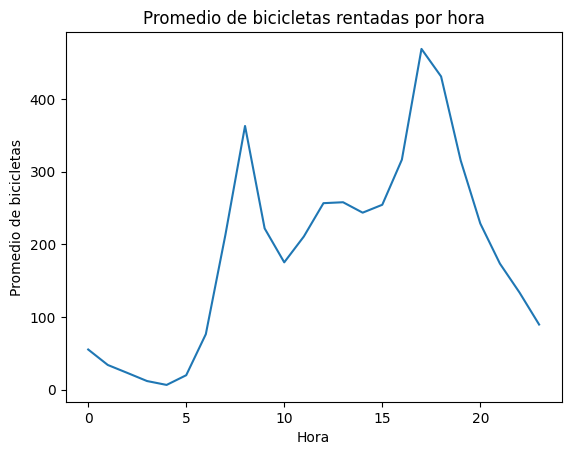

In [110]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora')
plt.ylabel('Promedio de bicicletas')
plt.xlabel('Hora')

Text(0.5, 0, 'Hora')

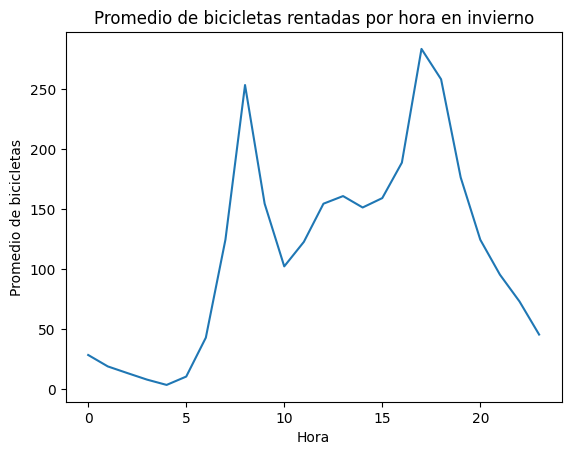

In [111]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora en invierno')
plt.ylabel('Promedio de bicicletas')
plt.xlabel('Hora')

Text(0.5, 0, 'Hora')

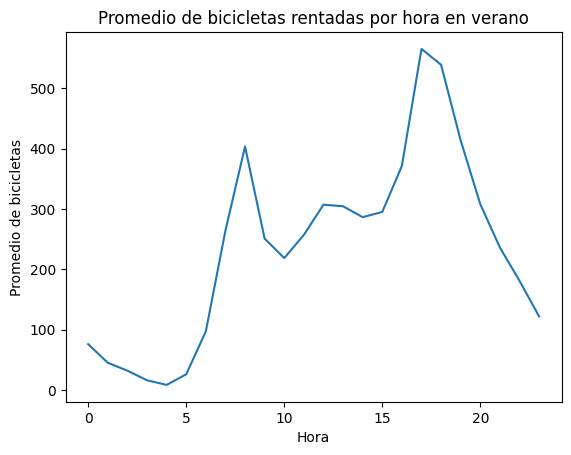

In [112]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora en verano')
plt.ylabel('Promedio de bicicletas')
plt.xlabel('Hora')

#### **Hallazgos y conclusiones**

* **Season 1 invierno**:
  * La demanda es baja y estable durante la madrugada
  * El primer pico significativo ocurre a las 8 am
  * Se mantiene una demanda sostenida durante el mediodía
  * El pico máximo ocurre a las 5 pm, seguido de una caída por la noche

* **Season 3 verano**:
  * El patrón es similar al del invierno, pero con una mayor cantidad de bicicletas rentadas (el rango del eje 'y' va por encima de 400, mientras que en invierno llegaba hasta 250 bicicletas)
  * La demanda es baja y estable durante la madrugada
  * El primer pico significativo ocurre a las 8 am
  * Se mantiene una demanda sostenida durante el mediodía y la tarde, más constante que en el invierno
  * El pico máximo ocurre a las 5 pm
  * La noche cae pero cuenta con niveles altos en comparación al invierno

* **Comparativa entre estaciones y el total**:
  * El comportamiento general (gráfica 1) tiene un comportamiento como el del invierno y verano, con picos de demanda para las 8 am y 5 pm y reducciones en la madrugada y la noche
  * El invierno se sitúa consistentemente por debajo del promedio total en todas las horas del día
  * El verano está por encima en la demanda promedio frente a la gráfica total (y al invierno)
  * La diferencia máxima entre verano e invierno se da a las 5 pm, con una brecha cercana a 200 bicicletas en promedio

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [138]:
# Celda 3
# Separación de variables predictoras (X) y variable de interes (y)
bikes_3 = bikes.copy()
X = bikes_3[['season', 'hour']]
y = bikes_3['total']

# Transformacion de la variable 'season' en variables dummy
X = pd.get_dummies(X, columns=['season'], drop_first=True)

# Separación de datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creación del modelo de regresión lineal
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

# Predicción de valores
y_pred_lineal = modelo_lineal.predict(X_test)

# Evaluación del modelo
mse_lineal = mean_squared_error(y_test, y_pred_lineal)
r2_lineal = r2_score(y_test, y_pred_lineal)
rmse_lineal = np.sqrt(mse_lineal)
mae_lineal = np.mean(np.abs(y_test - y_pred_lineal))

# Coeficientes del modelo
coeficientes_lineal = pd.Series(modelo_lineal.coef_, index=X.columns)
intercepto_lineal = modelo_lineal.intercept_

# Resultados
print("Resultados del modelo de regresión lineal:")
print(f"Error cuadrático medio (MSE): {mse_lineal:.4f}")
print(f"RMSE: {rmse_lineal:.4f}")
print(f"MAE: {mae_lineal:.4f}")
print(f"R^2: {r2_lineal:.4f}")
print("\nCoeficientes del modelo:")
print(f"Intercepto: {intercepto_lineal:.4f}")
print(f"Hour: {coeficientes_lineal['hour']:.4f}")
print(f"Primavera: {coeficientes_lineal['season_2']:.4f}")
print(f"Verano: {coeficientes_lineal['season_3']:.4f}")
print(f"Otoño: {coeficientes_lineal['season_4']:.4f}")



Resultados del modelo de regresión lineal:
Error cuadrático medio (MSE): 25592.2331
RMSE: 159.9757
MAE: 119.1172
R^2: 0.2135

Coeficientes del modelo:
Intercepto: -8.1872
Hour: 10.7270
Primavera: 99.7585
Verano: 115.0783
Otoño: 88.9182


#### **Conclusiones**

* **Interpretación de los coeficientes de la regresión**:
  * Intercepto (-8.18): representa el valor esperado de bicicletas rentadas cuando la hora es 0 (no que sean las 00.00 am sino igual a 0 la variable) y la estación es invierno (referencia)
  * Hour (10.72): por cada hora adicional del día, se espera un aumento promedio de 10.73 bicicletas rentadas, sin cambiar la estación
  * Primavera (99.755): en comparación con el invierno, la primavera representa un incremento promedio de 99.76 bicicletas rentadas, manteniendo la hora constante
  * Verano (115.07): en comparación con el invierno, el verano representa un incremento promedio de 115.07 bicicletas rentadas,manteniendo la hora constante
  * Otoño (88.91): en comparación con el invierno, el otoño representa un incremento promedio de 88.91 bicicletas rentadas, manteniendo la hora constante

* **¿Cuáles son las limitaciones de la regresión lineal en este caso?**:
  * La regresión lineal como está planteada no considera posibles interacciones entre hour y season, que podrían ser significativas, por ejemplo, el impacto de la hora varía la magnitud de la demanda según la estación (como se evidencio en el punto 2)
  * La relación entre la hora del día y la demanda no es estrictamente lineal, a partir del punto 1 y 2 se observan picos de demanda marcados en ciertas horas del día que un modelo lineal no puede capturar con precisión
  * El modelo tiene un coeficiente de determinacion R2 bajo (0.2135), indicando que el modelo solo explica el 21.35% de la variabilidad de la demanda total
  * Lo anterior evidencia que el modelo es muy simple, apenas usa dos variables. Deja de lado otras variables que podrían ser importantes como el clima, la temperatura, el dia de la semana, que podrían mejorar el ajuste

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [142]:
# Celda 4
# Definición de variables, parámetros y criterios de parada
X_tree = bikes[['season', 'hour']]
X_tree = pd.get_dummies(X_tree, columns=['season'], drop_first=True)
X_tree = X_tree.astype(float)
y_tree = bikes['total']


# Separacion de datos entre entrenamiento y prueba
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)


# Creación del modelo de árbol de decisión manual
# Funcion reduccion de varianza
def var_reduccion(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    var_y = y.var()
    var_l = y_l.var()
    var_r = y_r.var()
    
    var_reduccion_ = var_y - ((n_l / (n_l + n_r)) * var_l + (n_r / (n_l + n_r)) * var_r)
    
    return var_reduccion_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]
    
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2))[1:-1]
        splits = np.unique(splits)
        
        for split in splits:
            gain = var_reduccion(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']

    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        predicted[filter_l] = tree_predict(X.loc[filter_l], tree['sl'])
        predicted[~filter_l] = tree_predict(X.loc[~filter_l], tree['sr'])

    return predicted


# Definición de la función contador_nodos para contar el número de nodos en el árbol
def contador_nodos(tree):
    if tree['split'] == -1:
        return 1
    return contador_nodos(tree['sl']) + contador_nodos(tree['sr'])


# Entrenamiento y prediccion del árbol de decisión
tree = tree_grow(X_train_tree, y_train_tree, max_depth=21, min_gain=0.0001, num_pct=10)
y_pred_tree = tree_predict(X_test_tree, tree)

# Evaluación del árbol de decisión
mse_tree = mean_squared_error(y_test_tree, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test_tree, y_pred_tree)
mae_tree = np.mean(np.abs(y_test_tree - y_pred_tree))
n_nodos = contador_nodos(tree)

print("Resultados del árbol de decisión:")
print(f"Error cuadrático medio (MSE): {mse_tree:.4f}")
print(f"RMSE: {rmse_tree:.4f}")
print(f"MAE: {mae_tree:.4f}")
print(f"R^2: {r2_tree:.4f}")
print(f"Número de nodos: {n_nodos}")

Resultados del árbol de decisión:
Error cuadrático medio (MSE): 13778.6096
RMSE: 117.3823
MAE: 79.1937
R^2: 0.5766
Número de nodos: 85


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.


Resultados del árbol de decisión con sklearn:
Error cuadrático medio (MSE): 13825.1416
RMSE: 117.5804
MAE: 79.4916
R^2: 0.5751
Número de nodos: 157
Profundidad máxima: 8


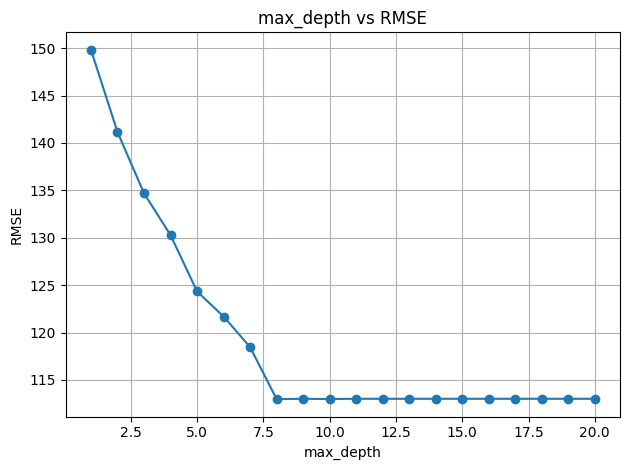

In [148]:
# Celda 5
# Definición de variables, parámetros y criterios de parada
X_tree = bikes[['season', 'hour']]
X_tree = pd.get_dummies(X_tree, columns=['season'], drop_first=True)
X_tree = X_tree.astype(float)
y_tree = bikes['total']


# Separacion de datos entre entrenamiento y prueba
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)
rmse_scores = []


# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse = -cross_val_score(clf, X_train_tree, y_train_tree, cv=10, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

    
# Entrenamiento y prediccion del árbol de decisión
mejor_depth = max_depth_range[np.argmin(rmse_scores)]
clf_final = DecisionTreeRegressor(max_depth=mejor_depth, random_state=1)
clf_final.fit(X_train_tree, y_train_tree)
y_pred_tree = clf_final.predict(X_test_tree)

# Evaluación del árbol de decisión
mse_tree = mean_squared_error(y_test_tree, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test_tree, y_pred_tree))
mae_tree = mean_absolute_error(y_test_tree, y_pred_tree)
r2_tree = r2_score(y_test_tree, y_pred_tree)
n_nodos = clf_final.tree_.node_count

print("\nResultados del árbol de decisión con sklearn:")
print(f"Error cuadrático medio (MSE): {mse_tree:.4f}")
print(f"RMSE: {rmse_tree:.4f}")
print(f"MAE: {mae_tree:.4f}")
print(f"R^2: {r2_tree:.4f}")
print(f"Número de nodos: {n_nodos}")
print(f"Profundidad máxima: {mejor_depth}")

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, rmse_scores, marker='o')
plt.title('max_depth vs RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Comparativa del desempeño frente al modelo de regresion lineal del punto 3**

In [147]:
# Comparativa de resultados entre modelos
print("\nComparativa de resultados entre modelos:")
print(f"Modelo de regresión lineal - RMSE: {rmse_lineal:.4f}, MAE: {mae_lineal:.4f}, R^2: {r2_lineal:.4f}")
print(f"Modelo de árbol de decisión - RMSE: {rmse_tree:.4f}, MAE: {mae_tree:.4f}, R^2: {r2_tree:.4f}")



Comparativa de resultados entre modelos:
Modelo de regresión lineal - RMSE: 159.9757, MAE: 119.1172, R^2: 0.2135
Modelo de árbol de decisión - RMSE: 117.5804, MAE: 79.4916, R^2: 0.5751


**Comparación de desempeño**:
  * El modelo de árbol de regresión obtiene un RMSE de 117.58, lo que indica que, en promedio, el error en la predicción del número de bicicletas rentadas es de aproximadamente 118 unidades
  * En contraste, la regresión lineal presenta un RMSE significativamente mayor de 159.98, mostrando predicciones  menos precisas
  * Al evaluar el coeficiente de determinacion R2 el árbol de regresión alcanza un valor de 0.575, lo que significa que explica el 57.5% de la variabilidad observada en la demanda de bicicletas.
  * Por su parte, el modelo de regresión lineal alcanza un R2 de 0.213, es decir que solo el 21.3% de la variabilidad es explicada por el modelo
  * Así entonces, **el arbol de decisión ofrece un mejor desempeño que la regresión lineal, tanto en términos de error absoluto promedio como en la capacidad explicativa del modelo**. Esto puede ser porque la relación entre las variable 'total', 'hour' y 'season' puede no ser completamente lineal

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [149]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [163]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [164]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [165]:
# Celda 6
# Regresion logistica
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Arbol de decision
# Calibracion de hiperparametro max_depth
param_grid = {'max_depth': range(1, 21)}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejor modelo
tree_clf = grid_search.best_estimator_
y_pred_tree = tree_clf.predict(X_test)

# Evaluación de los modelos
print("\nResultados del modelo de regresión logística:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_log)}")

print("\nResultados del modelo de árbol de decisión:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_tree):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_tree)}")



Resultados del modelo de regresión logística:
Accuracy: 0.6200
F1 Score: 0.6069
Confusion Matrix:
[[588 303]
 [381 528]]

Resultados del modelo de árbol de decisión:
Accuracy: 0.6533
F1 Score: 0.6537
Confusion Matrix:
[[587 304]
 [320 589]]


#### **Comparación de desempeño entre modelos**:
  * Accuracy: el árbol de decisión (65.33%) supera a la regresión logística (62.00%), indicando mejor desempeño general en clasificación
  * F1 Score: el árbol muestra mejor equilibrio entre precisión y recall que la regresión logística (0.6537 vs. 0.6069)
  * Matriz de confusión: el árbol de decisión predice menos falsos negativos (320 vs. 381), lo que indica mejor capacidad para identificar casos positivos
  * **El árbol de decisión tiene un mejor rendimiento comparado a la regresión logística**

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.


Resultados del modelo de Bagging con árbol de decisión 1:
Accuracy: 0.6639
F1 Score: 0.6611
Confusion Matrix:
[[605 286]
 [319 590]]

Resultados del modelo de Bagging con árbol de decisión 2:
Accuracy: 0.6511
F1 Score: 0.6424
Confusion Matrix:
[[608 283]
 [345 564]]

Resultados del modelo de Bagging con regresión logística:
Accuracy: 0.6222
F1 Score: 0.6087
Confusion Matrix:
[[591 300]
 [380 529]]

Resultados del modelo de Bagging con ensamble:
Accuracy: 0.6367
F1 Score: 0.6301
Confusion Matrix:
[[589 302]
 [352 557]]


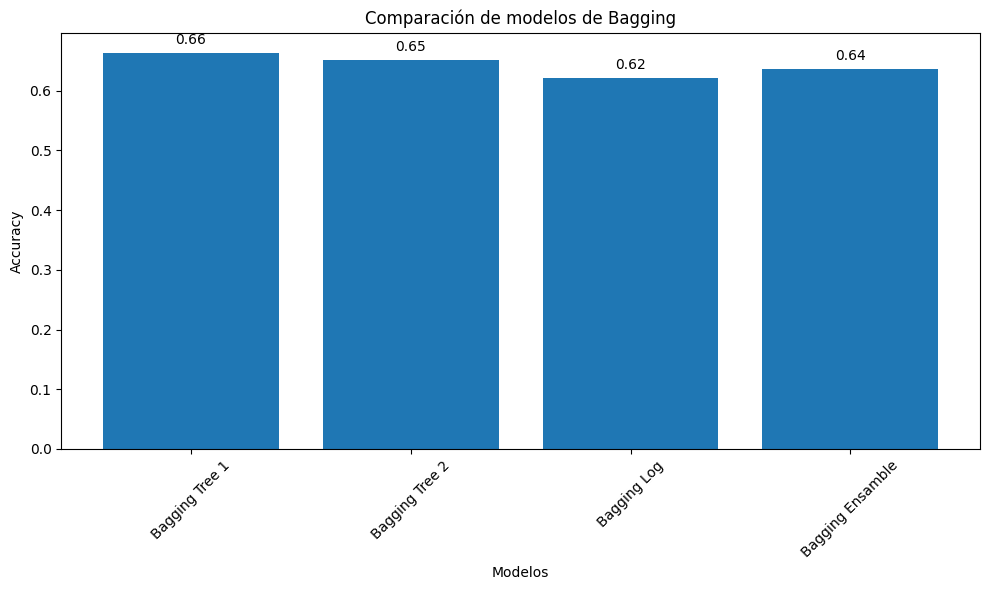

In [ ]:
# Celda 7
# Definicion de modelos
tree1 = DecisionTreeClassifier(max_depth=6, random_state=1)
tree2 = DecisionTreeClassifier(min_samples_leaf=10, random_state=1)
log_reg = LogisticRegression(max_iter=1000, random_state=1)

# Bagging de cada modelo con 100 estimadores
n_estimators = 100
bagged_tree1 = BaggingClassifier(estimator=tree1, n_estimators=n_estimators, random_state=1)
bagged_tree2 = BaggingClassifier(estimator=tree2, n_estimators=n_estimators, random_state=2)
bagged_log = BaggingClassifier(estimator=log_reg, n_estimators=n_estimators, random_state=3)

# Entrenamiento de los modelos
bagged_tree1.fit(X_train, y_train)
bagged_tree2.fit(X_train, y_train)
bagged_log.fit(X_train, y_train)

# Predicciones para cada estimador
preds_tree1 = np.array([est.predict(X_test) for est in bagged_tree1.estimators_])
preds_tree2 = np.array([est.predict(X_test) for est in bagged_tree2.estimators_])
preds_log = np.array([est.predict(X_test) for est in bagged_log.estimators_])

# Predicciones finales
pred_tree1_final = np.round(preds_tree1.mean(axis=0)).astype(int)
pred_tree2_final = np.round(preds_tree2.mean(axis=0)).astype(int)
pred_log_final = np.round(preds_log.mean(axis=0)).astype(int)

# Ensamble de modelos
ensamble = np.vstack([preds_tree1, preds_tree2, preds_log]) 

# Votación mayoritaria
y_pred_ensamble = (ensamble.sum(axis=0) >= ((n_estimators*3) / 2)).astype(int)

# Evaluación de los modelos
print("\nResultados del modelo de Bagging con árbol de decisión 1:")
print(f"Accuracy: {accuracy_score(y_test, pred_tree1_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_tree1_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_tree1_final)}")

print("\nResultados del modelo de Bagging con árbol de decisión 2:")
print(f"Accuracy: {accuracy_score(y_test, pred_tree2_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_tree2_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_tree2_final)}")

print("\nResultados del modelo de Bagging con regresión logística:")
print(f"Accuracy: {accuracy_score(y_test, pred_log_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_log_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_log_final)}")

print("\nResultados del modelo de Bagging con ensamble:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensamble):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ensamble):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_ensamble)}")


# Gráfica de comparación de resultados
plt.figure(figsize=(10, 6))
modelos = ['Bagging Tree 1', 'Bagging Tree 2', 'Bagging Log', 'Bagging Ensamble']
acc = [accuracy_score(y_test, pred_tree1_final), accuracy_score(y_test, pred_tree2_final), accuracy_score(y_test, pred_log_final), accuracy_score(y_test, y_pred_ensamble)]
bars = plt.bar(modelos, acc)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=10)
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de modelos de Bagging')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score


Resultados del modelo de Bagging con árbol de decisión 1:
Accuracy: 0.6639
F1 Score: 0.6611
Confusion Matrix:
[[605 286]
 [319 590]]

Resultados del modelo de Bagging con árbol de decisión 2:
Accuracy: 0.6511
F1 Score: 0.6424
Confusion Matrix:
[[608 283]
 [345 564]]

Resultados del modelo de Bagging con regresión logística:
Accuracy: 0.6222
F1 Score: 0.6087
Confusion Matrix:
[[591 300]
 [380 529]]

Resultados del ensamble con votación ponderada:
Pesos utilizados: Arbol 1=0.34, Arbol 2=0.34, Regresion Logistica=0.32
Accuracy: 0.6367
F1 Score: 0.6297
Confusion Matrix:
[[590 301]
 [353 556]]


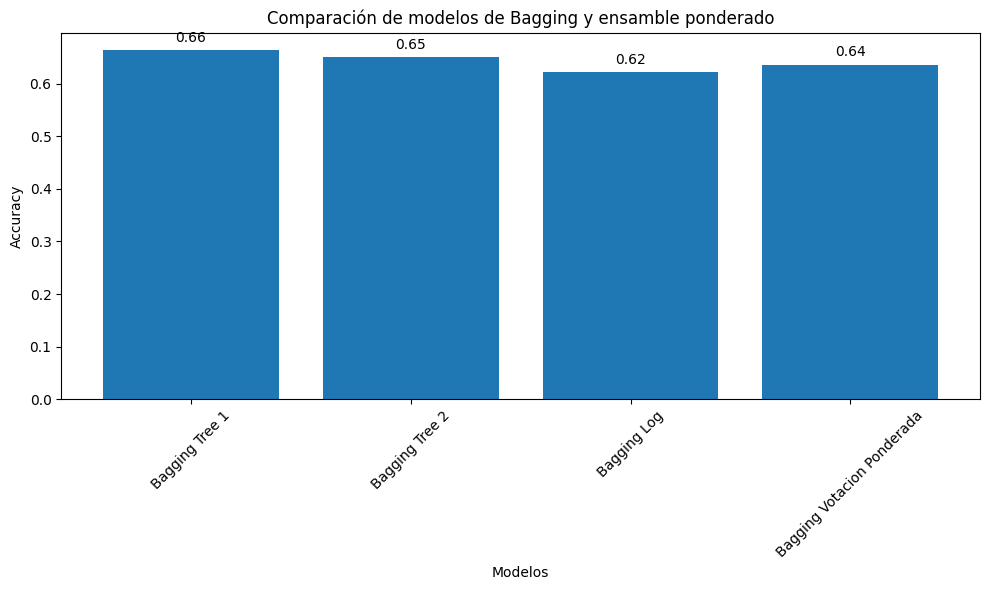

In [177]:
# Celda 8
# Definicion de modelos
tree1 = DecisionTreeClassifier(max_depth=6, random_state=1)
tree2 = DecisionTreeClassifier(min_samples_leaf=10, random_state=1)
log_reg = LogisticRegression(max_iter=1000, random_state=1)

# Bagging de cada modelo con 100 estimadores
n_estimators = 100
bagged_tree1 = BaggingClassifier(estimator=tree1, n_estimators=n_estimators, random_state=1)
bagged_tree2 = BaggingClassifier(estimator=tree2, n_estimators=n_estimators, random_state=2)
bagged_log = BaggingClassifier(estimator=log_reg, n_estimators=n_estimators, random_state=3)

# Entrenamiento de los modelos
bagged_tree1.fit(X_train, y_train)
bagged_tree2.fit(X_train, y_train)
bagged_log.fit(X_train, y_train)

# Predicciones para cada estimador
preds_tree1 = np.array([est.predict(X_test) for est in bagged_tree1.estimators_])
preds_tree2 = np.array([est.predict(X_test) for est in bagged_tree2.estimators_])
preds_log   = np.array([est.predict(X_test) for est in bagged_log.estimators_])

# Promedio de predicciones por grupo
voto_preds_tree1 = preds_tree1.mean(axis=0)
voto_preds_tree2 = preds_tree2.mean(axis=0)
voto_preds_log = preds_log.mean(axis=0)

# Predicciones finales
pred_tree1_final = np.round(voto_preds_tree1).astype(int)
pred_tree2_final = np.round(voto_preds_tree2).astype(int)
pred_log_final = np.round(voto_preds_log).astype(int)

# Cálculo del error fuera de muestra para cada grupo
error_tree1 = 1 - accuracy_score(y_test, pred_tree1_final)
error_tree2 = 1 - accuracy_score(y_test, pred_tree2_final)
error_log = 1 - accuracy_score(y_test, pred_log_final)

# Normalizacion de los pesos de los errores fuera de muestra
pesos = np.array([1 - error_tree1, 1 - error_tree2, 1 - error_log])
alpha = pesos / pesos.sum()

# Ensamble de modelo por votacion ponderada
votos_ponderados = (alpha[0] * voto_preds_tree1) + (alpha[1] * voto_preds_tree2) + (alpha[2] * voto_preds_log)
y_pred_ponderado = (votos_ponderados >= 0.5).astype(int)

# Evaluación de los modelos
print("\nResultados del modelo de Bagging con árbol de decisión 1:")
print(f"Accuracy: {accuracy_score(y_test, pred_tree1_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_tree1_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_tree1_final)}")

print("\nResultados del modelo de Bagging con árbol de decisión 2:")
print(f"Accuracy: {accuracy_score(y_test, pred_tree2_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_tree2_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_tree2_final)}")

print("\nResultados del modelo de Bagging con regresión logística:")
print(f"Accuracy: {accuracy_score(y_test, pred_log_final):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_log_final):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred_log_final)}")

# Evaluación del modelo de ensamble ponderado
print("\nResultados del ensamble con votación ponderada:")
#print(f"Pesos utilizados: {alpha}")
print(f"Pesos utilizados: Arbol 1={alpha[0]:.2f}, Arbol 2={alpha[1]:.2f}, Regresion Logistica={alpha[2]:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ponderado):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ponderado):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_ponderado)}")

# Gráfica de comparación de resultados
plt.figure(figsize=(10, 6))
modelos = ['Bagging Tree 1', 'Bagging Tree 2', 'Bagging Log', 'Bagging Votacion Ponderada']
acc = [accuracy_score(y_test, pred_tree1_final), accuracy_score(y_test, pred_tree2_final), accuracy_score(y_test, pred_log_final), accuracy_score(y_test, y_pred_ponderado)]
bars = plt.bar(modelos, acc)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=10)
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de modelos de Bagging y ensamble ponderado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

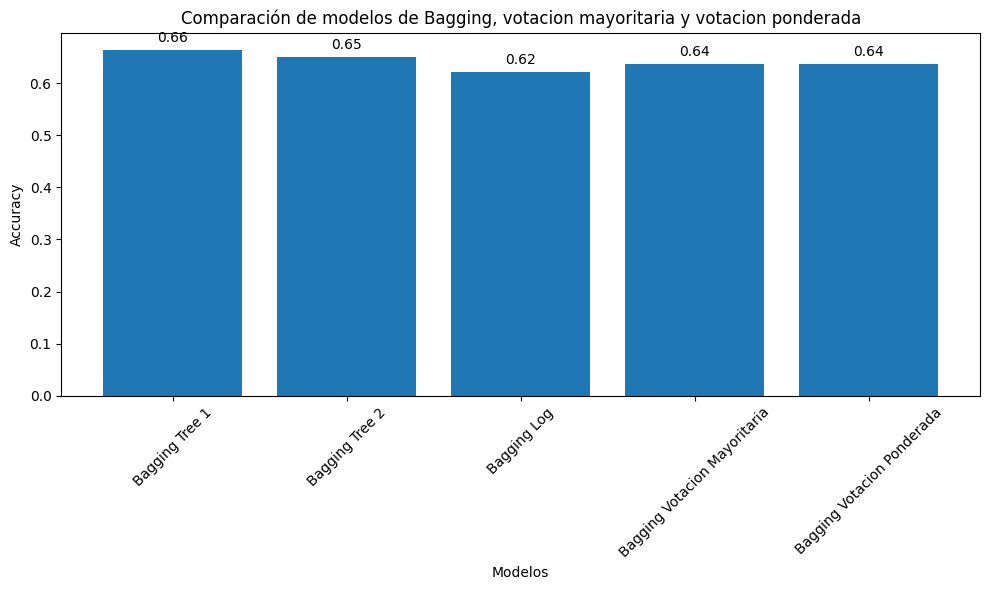

,Modelo,Accuracy,F1 Score
0,Bagging Tree 1,0.663889,0.661064
1,Bagging Tree 2,0.651111,0.642369
2,Bagging Log,0.622222,0.608746
3,Ensamble Vot. Mayoritaria,0.636667,0.630090
4,Ensamble Vot. Ponderada,0.636667,0.629672


In [180]:
# Celda 9
# Resultados de los puntos 7 y 8
# Gráfica de comparación de resultados
plt.figure(figsize=(10, 6))
modelos = ['Bagging Tree 1', 'Bagging Tree 2', 'Bagging Log', 'Bagging Votacion Mayoritaria', 'Bagging Votacion Ponderada']
acc = [accuracy_score(y_test, pred_tree1_final), accuracy_score(y_test, pred_tree2_final), accuracy_score(y_test, pred_log_final), accuracy_score(y_test, y_pred_ensamble), accuracy_score(y_test, y_pred_ponderado)]
bars = plt.bar(modelos, acc)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=10)
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de modelos de Bagging, votacion mayoritaria y votacion ponderada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Dataframe con los resultados de los modelos
resultados = {
    "Modelo": [
        "Bagging Tree 1",
        "Bagging Tree 2",
        "Bagging Log",
        "Ensamble Vot. Mayoritaria",
        "Ensamble Vot. Ponderada"
    ],
    "Accuracy": [
        accuracy_score(y_test, pred_tree1_final),
        accuracy_score(y_test, pred_tree2_final),
        accuracy_score(y_test, pred_log_final),
        accuracy_score(y_test, y_pred_ensamble),
        accuracy_score(y_test, y_pred_ponderado)
    ],
    "F1 Score": [
        f1_score(y_test, pred_tree1_final),
        f1_score(y_test, pred_tree2_final),
        f1_score(y_test, pred_log_final),
        f1_score(y_test, y_pred_ensamble),
        f1_score(y_test, y_pred_ponderado)
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

#### **Comparación y análisis de resultados de los puntos 7 y 8**

**Comparación de resultados**:
  * Bagging Tree 1 (max_depth=6) fue el modelo individual con mejor desempeño general (accuracy = 0.66, F1 = 0.66), mostrando buena capacidad de predicción y balance entre precisión y recall
  * Bagging Regresión Logística fue el menos preciso (accuracy = 0.62), aunque su F1 Score (= 0.61) muestra que logra un buen balance entre clases, al tratarse de un modelo lineal
  * Ensamble por votación mayoritaria (punto 7) tuvo un accuracy = 0.64 y un F1 Score = 0.63
  * Ensamble por votación ponderada (punto 8) obtuvo métricas muy similares al modelo anterior (accuracy = 0.64, F1 = 0.63), mostrando que ponderar por desempeño no cambió drásticamente los resultados.
  

**Conclusiones**:
  * El modelo de votación mayoritaria tiene como ventaja que permite reducir la varianza. No obstante, no considera la calidad individual de cada modelo, pues todos tienen el mismo peso.
  * El modelo de votación ponderada tiene como ventaja que ajusta el peso según el desempeño fuera de muestra; puede mejorar si hay modelos muy superiores. Sin embargo, en este caso los porcentajes de ponderación eran muy similares entre los tres modelos (debido a errores fuera de muestra similares entre los tres grupos de modelos), por lo que la votación ponderada no generó una mejora significativa respecto a la votación mayoritaria
  * Por lo anterior, **ninguno de los ensambles superó al mejor modelo individual (Bagging Tree 1), pero ambos mostraron mayor estabilidad general frente a los modelos más débiles.** Aunque los ensambles no siempre garantizan el rendimiento máximo, si logran mejorar la estabilidad y consisntencia.